## Set Up Environment

In [2]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np

import joblib

# Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Specific settings to enhance visualization in Jupyter notebooks
pd.set_option('display.max_rows', 50)  # Limit the maximum number of visible rows to improve performance.
pd.set_option('display.max_columns', None)  # Show all available columns

# System settings and handling of custom modules
import sys
sys.path.append('..')

# Import custom modules for specific functionalities
from utils.utils import (
    train_random_forest,
    train_random_forest_randomized,
    plot_and_get_top_features,
    evaluate_and_plot_model,
    plot_auc_roc
)

## Load Data

In [4]:
X_train = joblib.load('../../data/X_train.pkl')
X_test = joblib.load('../../data/X_test.pkl')
y_train = joblib.load('../../data/y_train.pkl')
y_test = joblib.load('../../data/y_test.pkl')

# Check the dimensions
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (136, 68) y_train: (136,)
X_test: (34, 68) y_test: (34,)


In [5]:
class_names = ['no rodilla', 'rodilla']

## Correlation between variables

In [7]:
X_train_with_target = X_train.copy()
X_train_with_target['Target'] = y_train
corr_matrix = X_train_with_target.corr()

threshold = 0.5 # Correlation threshold

# Find pairs with correlation above the threshold
strong_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
strong_pairs = strong_pairs.stack().reset_index()
strong_pairs.columns = ['variable1', 'variable2', 'correlation']

strong_pairs = strong_pairs[strong_pairs['correlation'] > threshold]  # Filter pairs with strong correlation.
strong_pairs = strong_pairs.sort_values('correlation', ascending=False) # Sort by correlation
strong_pairs

,variable1,variable2,correlation
2173,2heel raise,heel raise,1.000000
339,pace,step length,0.946542
325,pace,velocidad,0.895148
260,peso,imc,0.874890
134,altura,num calzado,0.837741
400,velocidad,step length,0.813111
567,shock,impact gs,0.804597
198,peso,num calzado,0.788302
69,sexo,num calzado,0.781624
568,shock,braking gs,0.765719


# Random Forest

### Model 1 - Without Feature Selection

Fitting 5 folds for each of 342 candidates, totalling 1710 fits
Best mean cross-validation score: 0.590
Best parameters: {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}


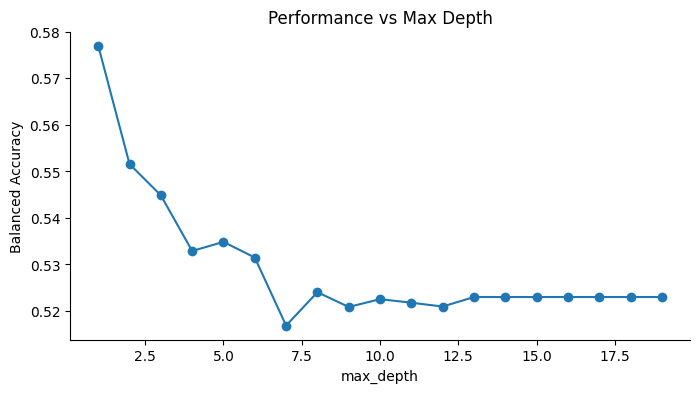

In [10]:
param_grid = {
    'max_depth': range(1, 20),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = train_random_forest(X_train, y_train, param_grid, n_jobs=-1, cv=5)

In [11]:
# Model evaluation
train_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9559
Test Accuracy: 0.6471


Resultados para RandomForestClassifier:
Accuracy: 0.6471
Precision: 0.6491
Recall: 0.6471
F1 Score: 0.6458


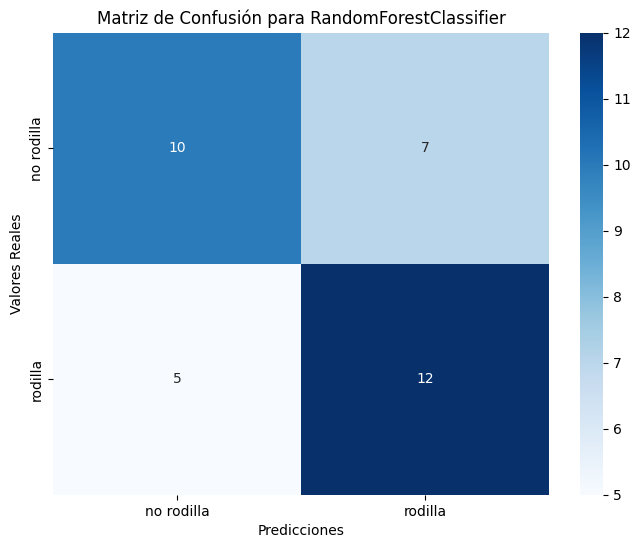

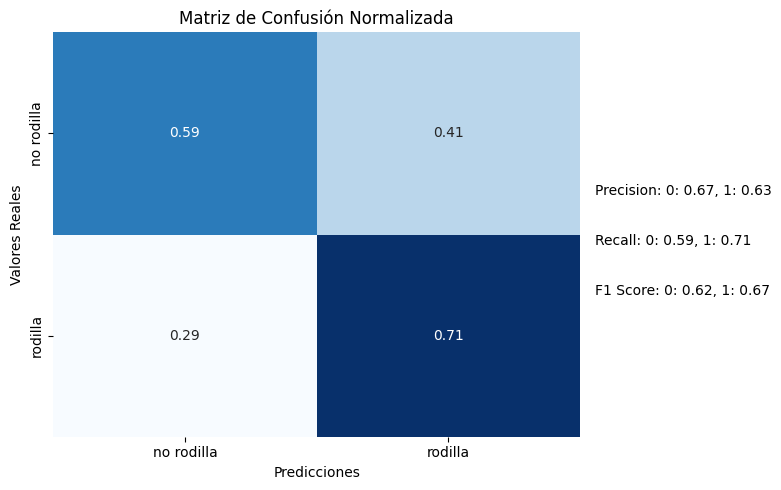


Classification Report:

              precision    recall  f1-score   support

  no rodilla       0.67      0.59      0.62        17
     rodilla       0.63      0.71      0.67        17

    accuracy                           0.65        34
   macro avg       0.65      0.65      0.65        34
weighted avg       0.65      0.65      0.65        34



In [12]:
evaluate_and_plot_model(rf, X_test, y_test, class_names)

AUC-ROC: 0.6886


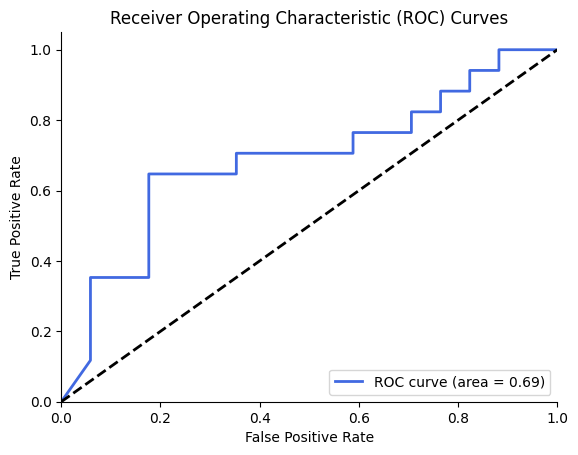

In [13]:
plot_auc_roc(rf, X_test, y_test, class_names)

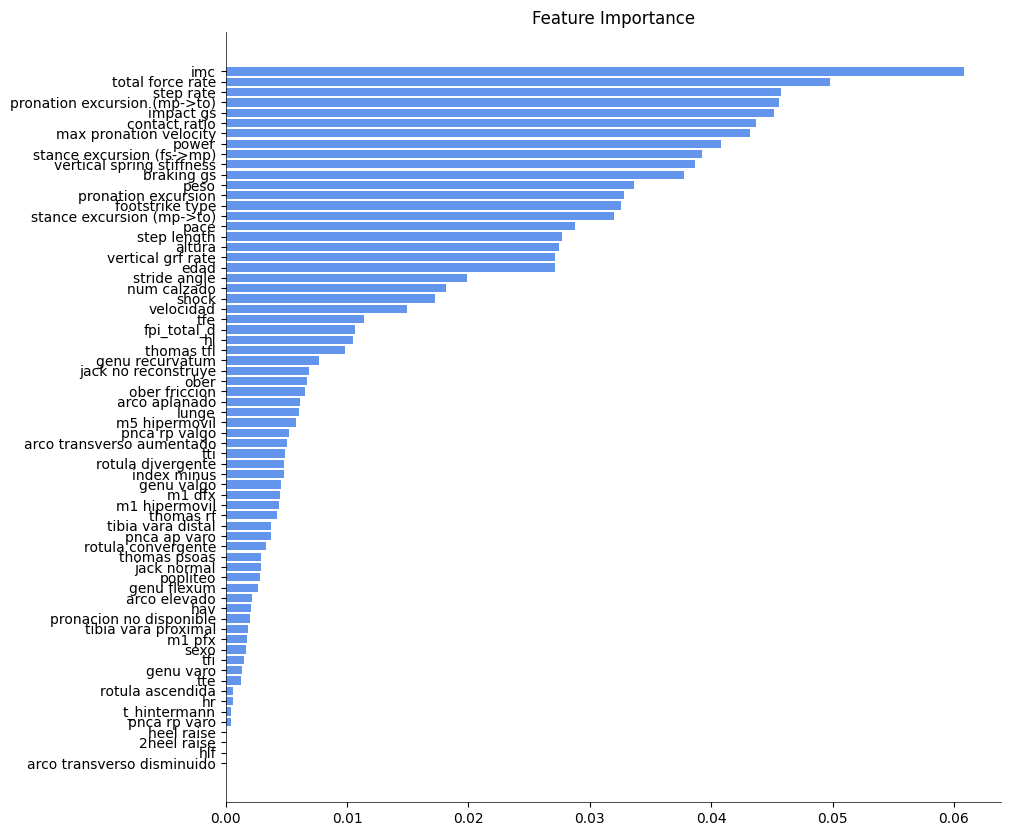

The top 30 most important features are:
['imc' 'total force rate' 'step rate' 'pronation excursion (mp->to)'
 'impact gs' 'contact ratio' 'max pronation velocity' 'power'
 'stance excursion (fs->mp)' 'vertical spring stiffness' 'braking gs'
 'peso' 'pronation excursion' 'footstrike type'
 'stance excursion (mp->to)' 'pace' 'step length' 'altura'
 'vertical grf rate' 'edad' 'stride angle' 'num calzado' 'shock'
 'velocidad' 'tfe' 'fpi_total_d' 'hl' 'thomas tfl' 'genu recurvatum'
 'jack no reconstruye']


In [14]:
top_features_30 = plot_and_get_top_features(rf, X_train, top_n=30)

In [15]:
# Get the importance of the features
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# List to store cross-validation scores
cv_scores = []

# Try different numbers of features
for i in range(1, len(feature_importances) + 1):
    top_features = feature_importances.index[:i]
    X_train_subset = X_train[top_features]
    
    # Evaluate the model using cross-validation
    scores = cross_val_score(RandomForestClassifier(random_state=42), X_train_subset, y_train, cv=5)
    cv_scores.append(scores.mean())

# Finding the optimal number of features
optimal_features = np.argmax(cv_scores) + 1

print(f"The optimal number of features is: {optimal_features}")

The optimal number of features is: 16


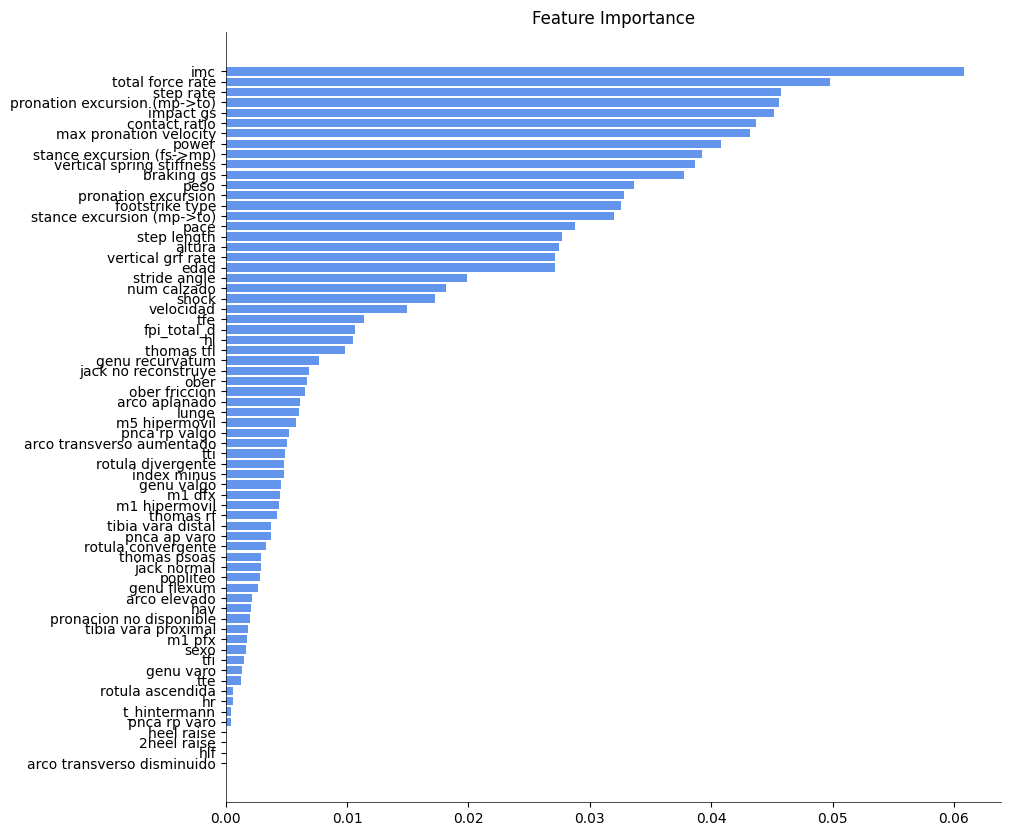

The top 16 most important features are:
['imc' 'total force rate' 'step rate' 'pronation excursion (mp->to)'
 'impact gs' 'contact ratio' 'max pronation velocity' 'power'
 'stance excursion (fs->mp)' 'vertical spring stiffness' 'braking gs'
 'peso' 'pronation excursion' 'footstrike type'
 'stance excursion (mp->to)' 'pace']


In [16]:
top_features_optimal = plot_and_get_top_features(rf, X_train, top_n=optimal_features)

### Model 2 - With Feature Selection

Fitting 10 folds for each of 342 candidates, totalling 3420 fits
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END max_depth=2, m

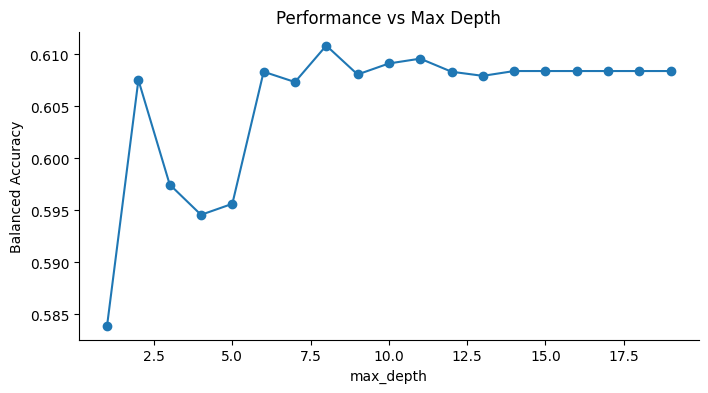

In [18]:
param_grid = {
    'max_depth': range(1, 20),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Selection of important features
X_train_best_rf2 = X_train[top_features_30]
X_test_best_rf2 = X_test[top_features_30]

best_rf2 = train_random_forest(X_train_best_rf2, y_train, param_grid, n_jobs=-1, cv=10)

In [19]:
# Model evaluation
train_accuracy = best_rf2.score(X_train_best_rf2, y_train)
test_accuracy = best_rf2.score(X_test_best_rf2, y_test)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9779
Test Accuracy: 0.7353


Resultados para RandomForestClassifier:
Accuracy: 0.7353
Precision: 0.7361
Recall: 0.7353
F1 Score: 0.7351


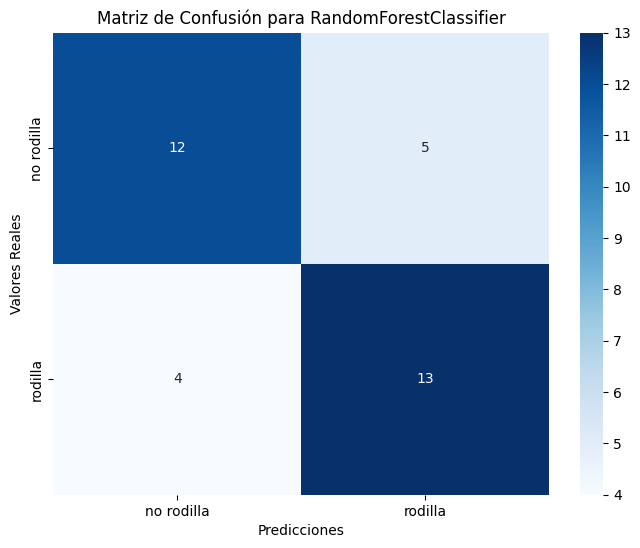

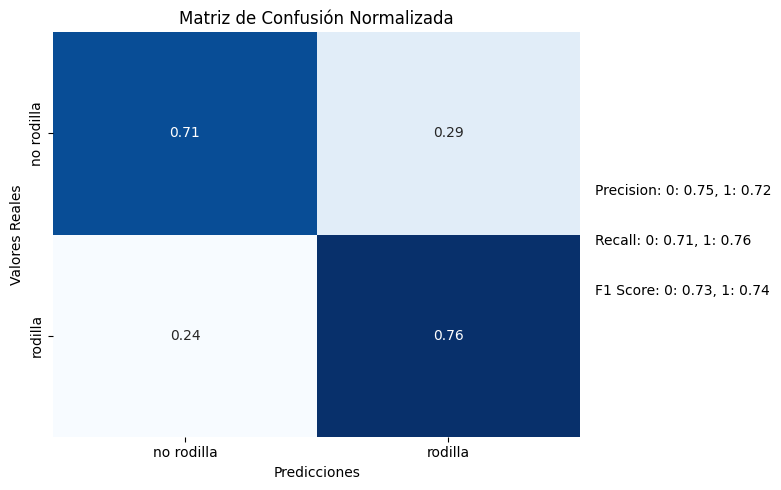


Classification Report:

              precision    recall  f1-score   support

  no rodilla       0.75      0.71      0.73        17
     rodilla       0.72      0.76      0.74        17

    accuracy                           0.74        34
   macro avg       0.74      0.74      0.74        34
weighted avg       0.74      0.74      0.74        34



In [20]:
evaluate_and_plot_model(best_rf2, X_test_best_rf2, y_test, class_names)

AUC-ROC: 0.7612


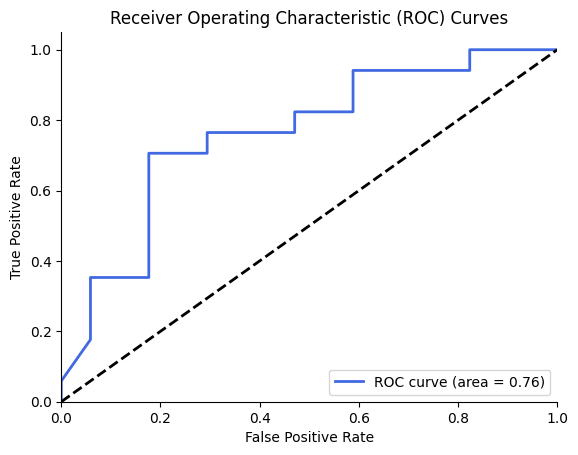

In [21]:
plot_auc_roc(best_rf2, X_test_best_rf2, y_test, class_names)

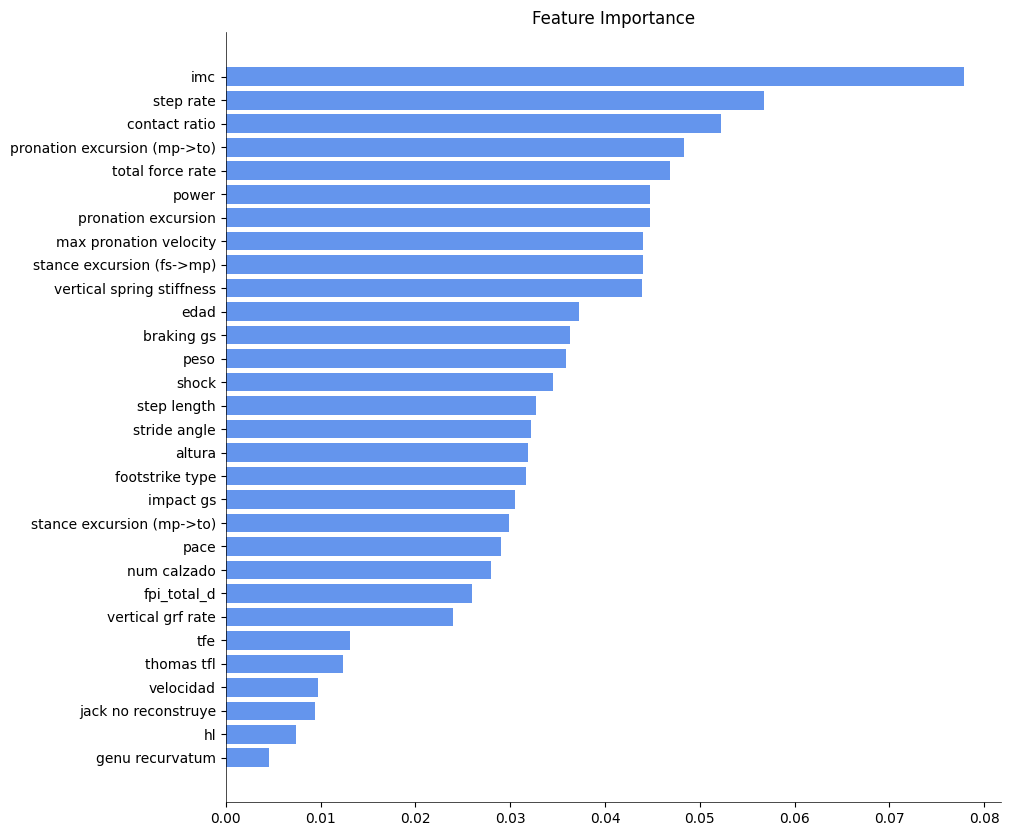

The top 30 most important features are:
['imc' 'step rate' 'contact ratio' 'pronation excursion (mp->to)'
 'total force rate' 'power' 'pronation excursion' 'max pronation velocity'
 'stance excursion (fs->mp)' 'vertical spring stiffness' 'edad'
 'braking gs' 'peso' 'shock' 'step length' 'stride angle' 'altura'
 'footstrike type' 'impact gs' 'stance excursion (mp->to)' 'pace'
 'num calzado' 'fpi_total_d' 'vertical grf rate' 'tfe' 'thomas tfl'
 'velocidad' 'jack no reconstruye' 'hl' 'genu recurvatum']


In [22]:
top_features = plot_and_get_top_features(best_rf2, X_train_best_rf2, top_n=30)

In [23]:
# Save the trained model
model_filename = '../../src/models/random_forest_model.pkl'
joblib.dump(best_rf2, model_filename)

print(f"Modelo guardado como {model_filename}")

Modelo guardado como ../../src/models/random_forest_model.pkl


In [24]:
# Select a sample of real test data
n_samples = 10
X_test_sample = X_test_best_rf2.head(n_samples)
y_test_sample = y_test.head(n_samples)

# Making predictions using the model
predicciones = best_rf2.predict(X_test_sample)
probabilidades = best_rf2.predict_proba(X_test_sample)[:, 1]

# Show the results
for i, (pred, prob, real) in enumerate(zip(predicciones, probabilidades, y_test_sample)):
    print(f"Prueba {i+1}:")
    print(f"Predicción: {'Rodilla' if pred == 1 else 'No Rodilla'}")
    print(f"Probabilidad de Rodilla: {prob:.2f}")
    print(f"Valor Real: {'Rodilla' if real == 1 else 'No Rodilla'}")
    print()

Prueba 1:
Predicción: No Rodilla
Probabilidad de Rodilla: 0.46
Valor Real: No Rodilla

Prueba 2:
Predicción: Rodilla
Probabilidad de Rodilla: 0.81
Valor Real: Rodilla

Prueba 3:
Predicción: Rodilla
Probabilidad de Rodilla: 0.56
Valor Real: Rodilla

Prueba 4:
Predicción: No Rodilla
Probabilidad de Rodilla: 0.37
Valor Real: No Rodilla

Prueba 5:
Predicción: No Rodilla
Probabilidad de Rodilla: 0.44
Valor Real: No Rodilla

Prueba 6:
Predicción: No Rodilla
Probabilidad de Rodilla: 0.45
Valor Real: No Rodilla

Prueba 7:
Predicción: Rodilla
Probabilidad de Rodilla: 0.76
Valor Real: Rodilla

Prueba 8:
Predicción: Rodilla
Probabilidad de Rodilla: 0.65
Valor Real: No Rodilla

Prueba 9:
Predicción: Rodilla
Probabilidad de Rodilla: 0.81
Valor Real: Rodilla

Prueba 10:
Predicción: Rodilla
Probabilidad de Rodilla: 0.60
Valor Real: Rodilla



### Model 3 - RandomisedSearchCV

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.2s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.2s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=4, 

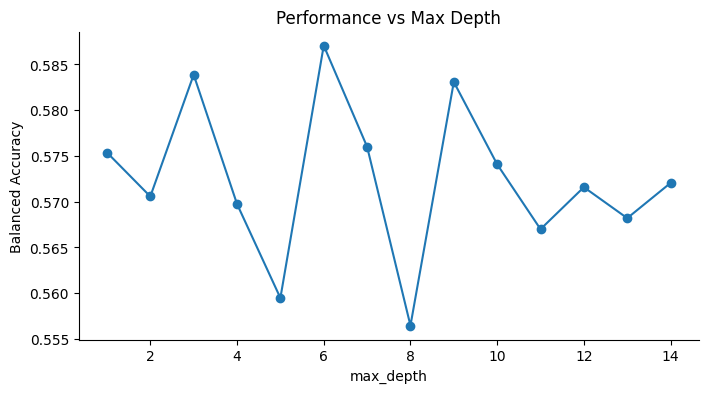

Resultados con las características seleccionadas y los mejores hiperparámetros:
              precision    recall  f1-score   support

  no rodilla       0.71      0.71      0.71        17
     rodilla       0.71      0.71      0.71        17

    accuracy                           0.71        34
   macro avg       0.71      0.71      0.71        34
weighted avg       0.71      0.71      0.71        34

Train Accuracy: 0.9706
Test Accuracy: 0.7059


In [26]:
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': range(1, 15),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Train and evaluate the RandomForest model with the selected features and the best hyperparameters.
best_rf3 = train_random_forest_randomized(X_train, y_train, param_distributions)

y_pred = best_rf3.predict(X_test)

print("Resultados con las características seleccionadas y los mejores hiperparámetros:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Calculate the accuracy on the training and test set
train_accuracy = best_rf3.score(X_train, y_train)
test_accuracy = best_rf3.score(X_test, y_test)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [27]:
# Model evaluation
train_accuracy = best_rf3.score(X_train, y_train)
test_accuracy = best_rf3.score(X_test, y_test)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9706
Test Accuracy: 0.7059


Resultados para RandomForestClassifier:
Accuracy: 0.7059
Precision: 0.7059
Recall: 0.7059
F1 Score: 0.7059


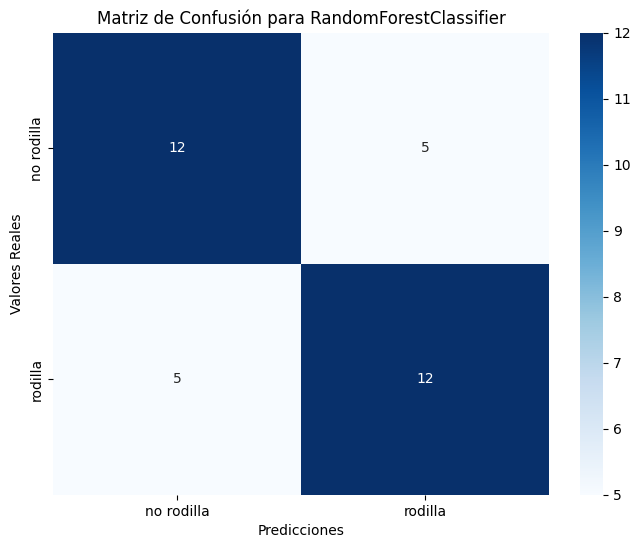

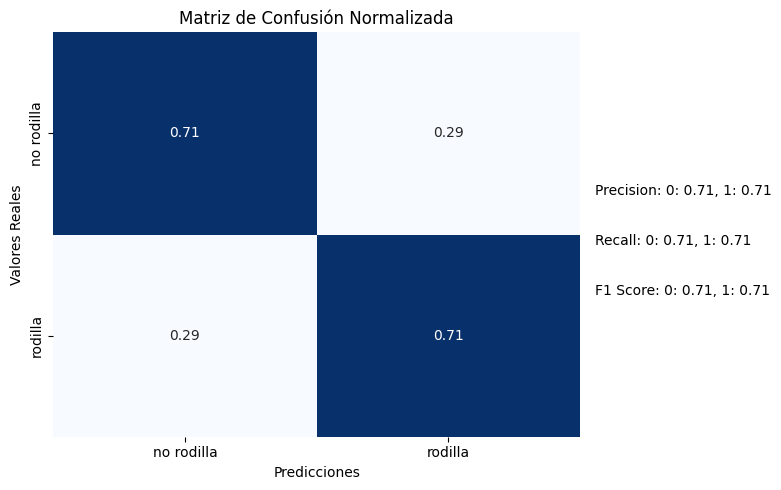


Classification Report:

              precision    recall  f1-score   support

  no rodilla       0.71      0.71      0.71        17
     rodilla       0.71      0.71      0.71        17

    accuracy                           0.71        34
   macro avg       0.71      0.71      0.71        34
weighted avg       0.71      0.71      0.71        34



In [28]:
evaluate_and_plot_model(best_rf3, X_test, y_test, class_names)

AUC-ROC: 0.7232


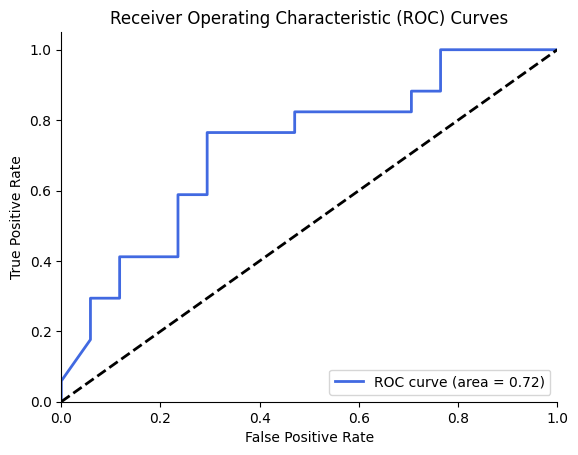

In [29]:
plot_auc_roc(best_rf3, X_test, y_test, class_names)

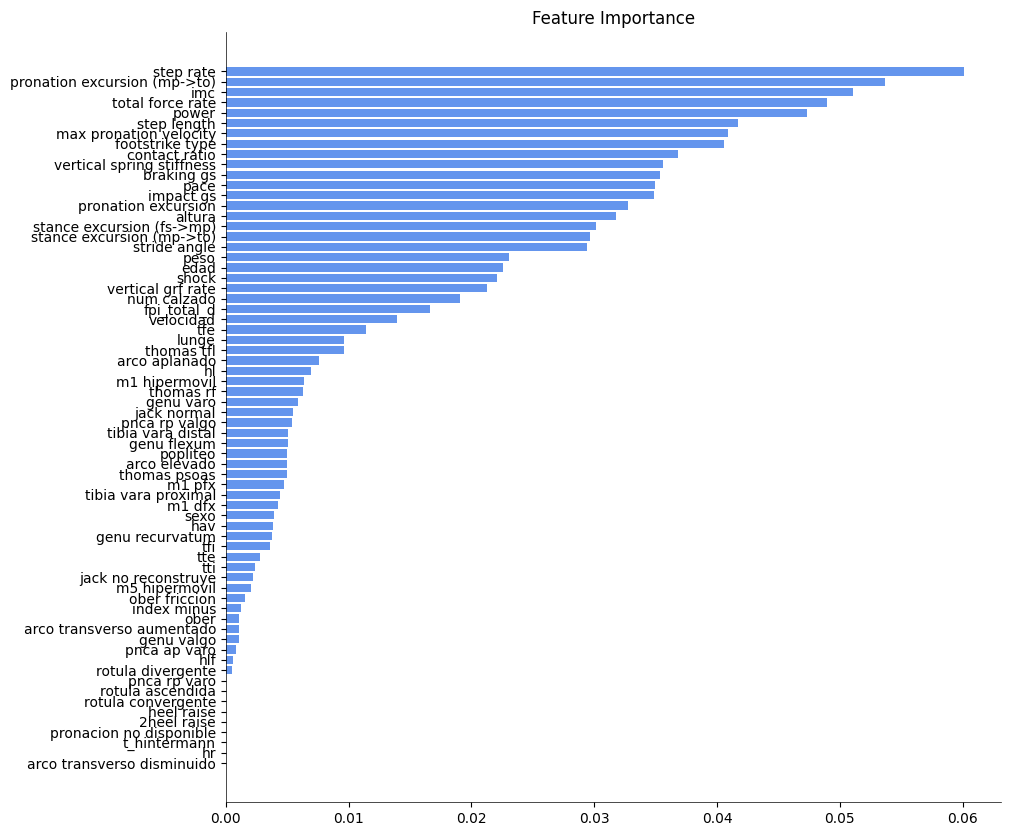

The top 40 most important features are:
['step rate' 'pronation excursion (mp->to)' 'imc' 'total force rate'
 'power' 'step length' 'max pronation velocity' 'footstrike type'
 'contact ratio' 'vertical spring stiffness' 'braking gs' 'pace'
 'impact gs' 'pronation excursion' 'altura' 'stance excursion (fs->mp)'
 'stance excursion (mp->to)' 'stride angle' 'peso' 'edad' 'shock'
 'vertical grf rate' 'num calzado' 'fpi_total_d' 'velocidad' 'tfe' 'lunge'
 'thomas tfl' 'arco aplanado' 'hl' 'm1 hipermovil' 'thomas rf' 'genu varo'
 'jack normal' 'pnca rp valgo' 'tibia vara distal' 'genu flexum'
 'popliteo' 'arco elevado' 'thomas psoas']


In [30]:
top_features_40 = plot_and_get_top_features(best_rf3, X_train, top_n=40)

### Model 4 - RandomizedSearchCV With Feature Selection

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.2s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.2s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=4, max_fe

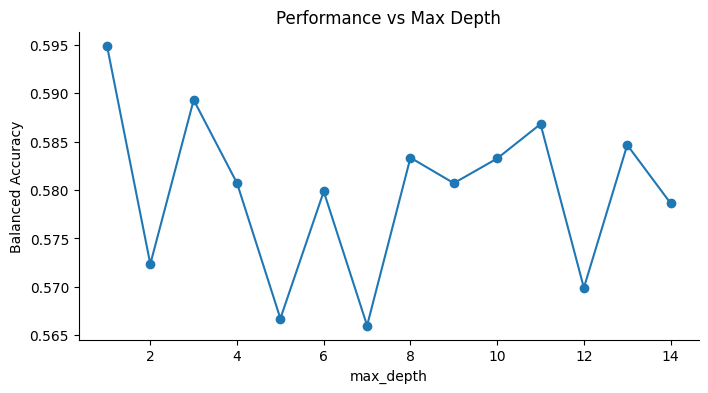

Resultados con las características seleccionadas y los mejores hiperparámetros:
              precision    recall  f1-score   support

  no rodilla       0.71      0.59      0.65        17
     rodilla       0.65      0.76      0.70        17

    accuracy                           0.68        34
   macro avg       0.68      0.68      0.67        34
weighted avg       0.68      0.68      0.67        34



In [32]:
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': range(1, 15),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Selection of important features
X_train_best_rf4 = X_train[top_features_40]
X_test_best_rf4 = X_test[top_features_40]

# Train and evaluate the RandomForest model using the selected features and the best hyperparameters.
best_rf4 = train_random_forest_randomized(X_train_best_rf4, y_train, param_distributions)

y_pred = best_rf4.predict(X_test_best_rf4)

print("Resultados con las características seleccionadas y los mejores hiperparámetros:")
print(classification_report(y_test, y_pred, target_names=class_names))

In [33]:
# Calculate the accuracy on the training and test set
train_accuracy = best_rf4.score(X_train_best_rf4, y_train)
test_accuracy = best_rf4.score(X_test_best_rf4, y_test)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9779
Test Accuracy: 0.6765


Resultados para RandomForestClassifier:
Accuracy: 0.6765
Precision: 0.6821
Recall: 0.6765
F1 Score: 0.6739


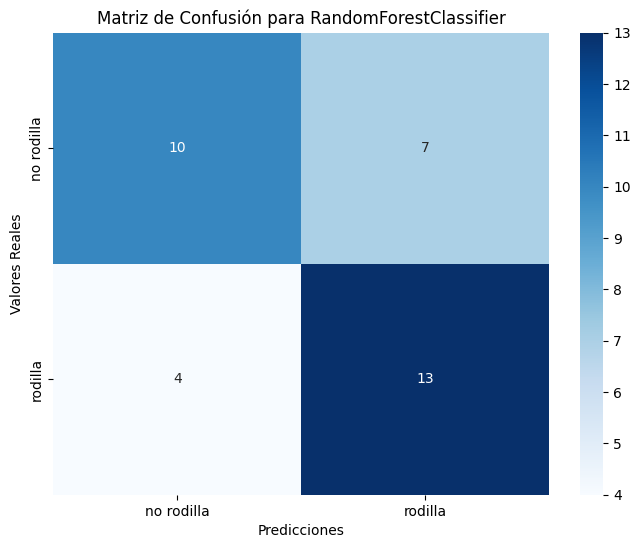

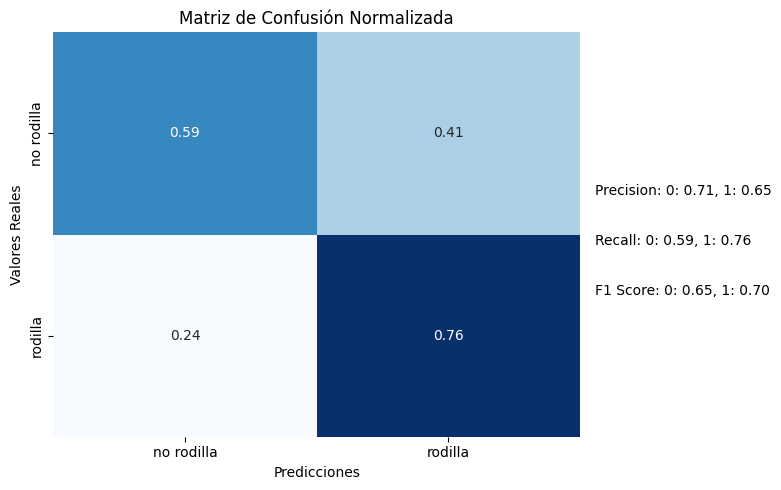


Classification Report:

              precision    recall  f1-score   support

  no rodilla       0.71      0.59      0.65        17
     rodilla       0.65      0.76      0.70        17

    accuracy                           0.68        34
   macro avg       0.68      0.68      0.67        34
weighted avg       0.68      0.68      0.67        34



In [34]:
evaluate_and_plot_model(best_rf4, X_test_best_rf4, y_test, class_names)

AUC-ROC: 0.7509


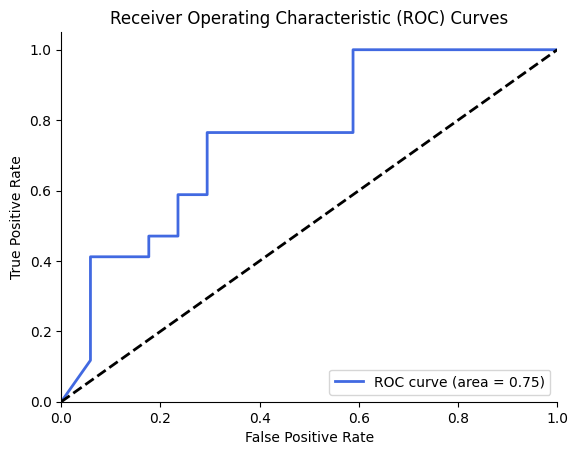

In [35]:
plot_auc_roc(best_rf4, X_test_best_rf4, y_test, class_names)

### Model 5 with manual feature selection

Fitting 10 folds for each of 342 candidates, totalling 3420 fits
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10; total time=   0.2s
[CV] END max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END max_depth=16, max_features=log2, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END max_depth=16, max_features=log2, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END

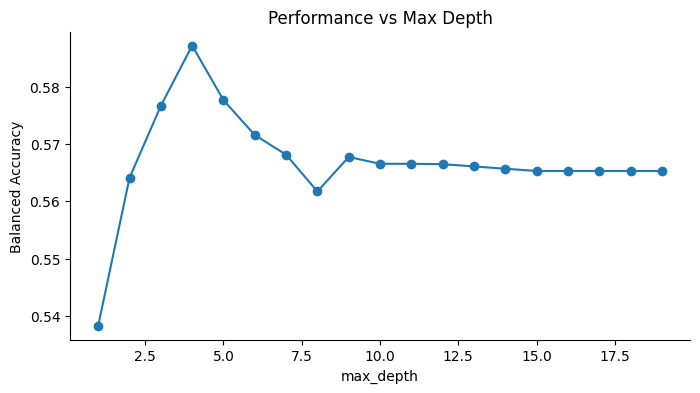

In [37]:
features_selected = ['edad', 'sexo', 'altura', 'peso', 'num calzado',
       'pace', 'velocidad', 'step rate', 'power', 'shock', 'impact gs',
       'braking gs', 'footstrike type', 'pronation excursion',
       'max pronation velocity', 'contact ratio',
       'stride angle', 'vertical spring stiffness',
       'vertical grf rate', 'total force rate', 'step length',
       'pronation excursion (mp->to)', 'stance excursion (fs->mp)',
       'stance excursion (mp->to)', 'arco aplanado', 'hav', 'index minus',
       'tfi', 'tfe', 'tte', 'popliteo',
       'jack no reconstruye', 'fpi_total_d', 'tibia vara proximal',
       'tibia vara distal', 'genu valgo', 'genu varo', 'genu recurvatum',
       'genu flexum', 'lunge', 'imc']
    
param_grid = {
    'max_depth': range(1, 20),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Selection of important features
X_train_best_rf5 = X_train[features_selected]
X_test_best_rf5 = X_test[features_selected]

best_rf5 = train_random_forest(X_train_best_rf5, y_train, param_grid, n_jobs=-1, cv=10)

In [38]:
# Calculate the accuracy on the training and test set.
train_accuracy = best_rf5.score(X_train_best_rf5, y_train)
test_accuracy = best_rf5.score(X_test_best_rf5, y_test)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9779
Test Accuracy: 0.6471


Resultados para RandomForestClassifier:
Accuracy: 0.6471
Precision: 0.6491
Recall: 0.6471
F1 Score: 0.6458


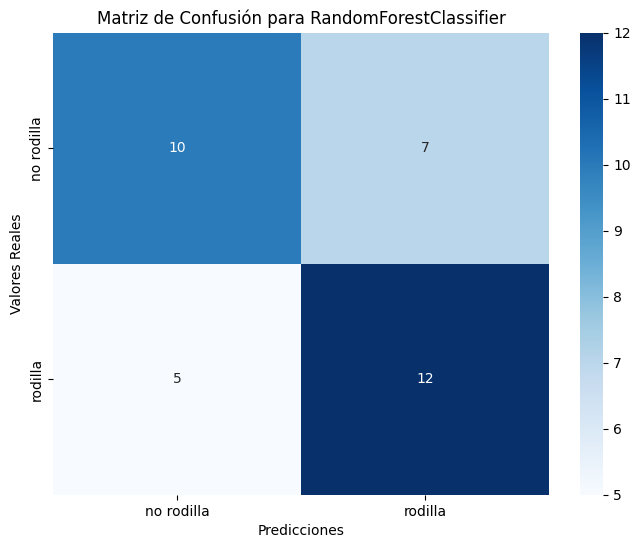

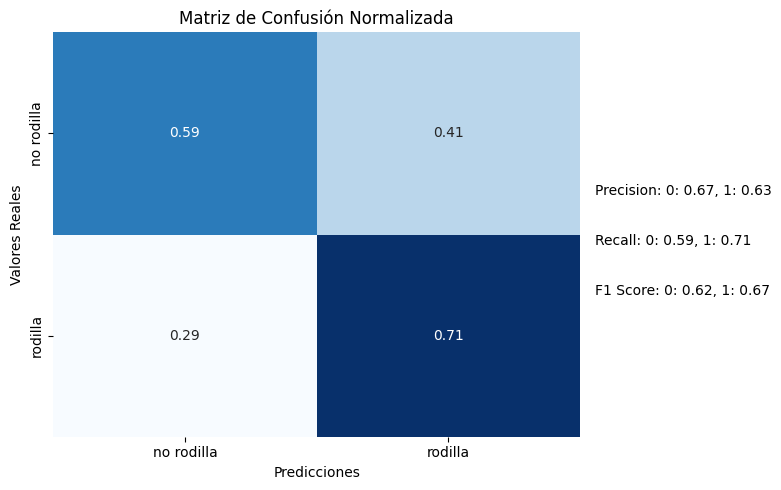


Classification Report:

              precision    recall  f1-score   support

  no rodilla       0.67      0.59      0.62        17
     rodilla       0.63      0.71      0.67        17

    accuracy                           0.65        34
   macro avg       0.65      0.65      0.65        34
weighted avg       0.65      0.65      0.65        34



In [39]:
evaluate_and_plot_model(best_rf5, X_test_best_rf5, y_test, class_names)

AUC-ROC: 0.7059


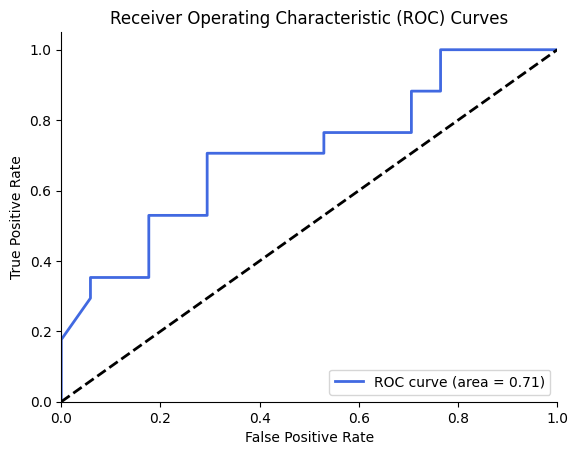

In [40]:
plot_auc_roc(best_rf5, X_test_best_rf5, y_test, class_names)

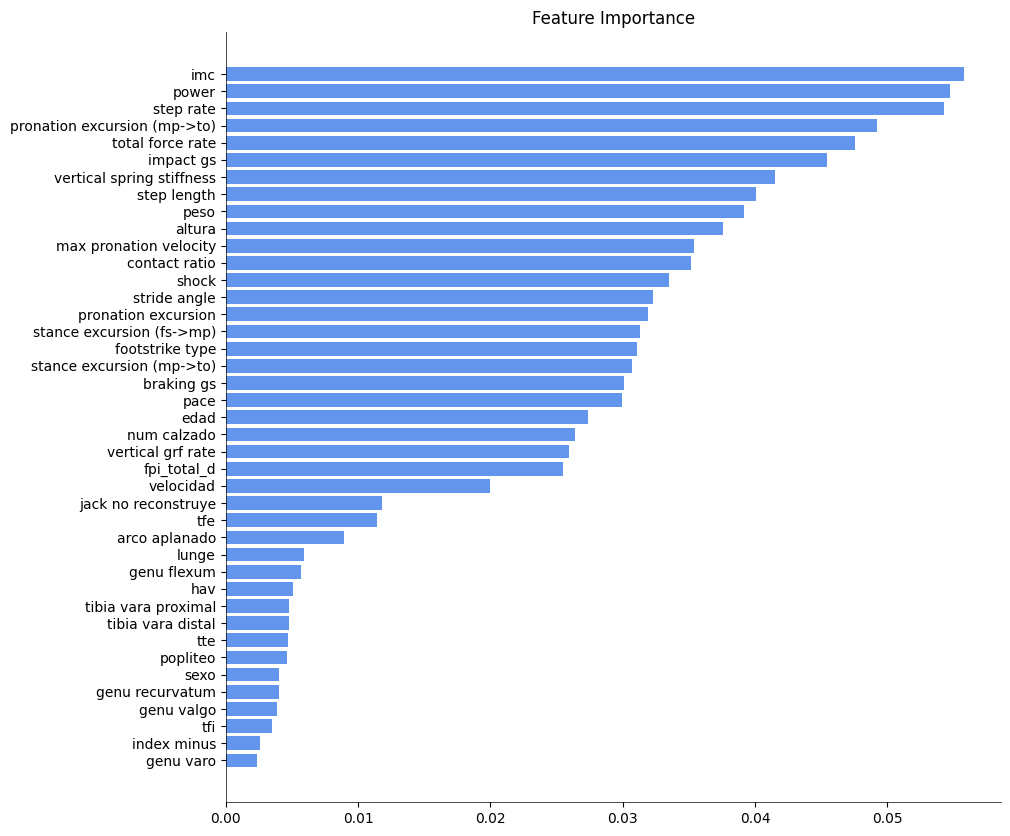

The top 30 most important features are:
['imc' 'power' 'step rate' 'pronation excursion (mp->to)'
 'total force rate' 'impact gs' 'vertical spring stiffness' 'step length'
 'peso' 'altura' 'max pronation velocity' 'contact ratio' 'shock'
 'stride angle' 'pronation excursion' 'stance excursion (fs->mp)'
 'footstrike type' 'stance excursion (mp->to)' 'braking gs' 'pace' 'edad'
 'num calzado' 'vertical grf rate' 'fpi_total_d' 'velocidad'
 'jack no reconstruye' 'tfe' 'arco aplanado' 'lunge' 'genu flexum']


In [41]:
top_features_30 = plot_and_get_top_features(best_rf5, X_train_best_rf5, top_n=30)

## Test the best model 2 with dummy data

In [43]:
features = ['imc', 'total force rate', 'step rate', 'pronation excursion (mp->to)',
            'impact gs', 'contact ratio', 'max pronation velocity', 'power',
            'stance excursion (fs->mp)', 'vertical spring stiffness', 'braking gs',
            'peso', 'pronation excursion', 'footstrike type', 'stance excursion (mp->to)',
            'pace', 'step length', 'altura', 'vertical grf rate', 'edad', 'stride angle',
            'num calzado', 'shock', 'velocidad', 'tfe', 'fpi_total_d', 'hl', 'thomas tfl',
            'genu recurvatum', 'jack no reconstruye']

# Define the statistics based on the provided data
stats = {
    'imc': {'mean': 22.743, 'std': 2.931},
    'total force rate': {'mean': 71.532, 'std': 20.646},
    'step rate': {'mean': 164.099, 'std': 8.679},
    'pronation excursion (mp->to)': {'mean': 0.598, 'std': 6.961},
    'impact gs': {'mean': 7.421, 'std': 2.698},
    'contact ratio': {'mean': 79.543, 'std': 9.638},
    'max pronation velocity': {'mean': 532.716, 'std': 239.946},
    'power': {'mean': 226.681, 'std': 76.645},
    'stance excursion (fs->mp)': {'mean': 14.964, 'std': 12.050},
    'vertical spring stiffness': {'mean': 16.858, 'std': 7.140},
    'braking gs': {'mean': 5.919, 'std': 2.277},
    'peso': {'mean': 69.713, 'std': 12.983},
    'pronation excursion': {'mean': -13.574, 'std': 7.173},
    'footstrike type': {'mean': 8.581, 'std': 3.666},
    'stance excursion (mp->to)': {'mean': 64.736, 'std': 8.716},
    'pace': {'mean': 3.226, 'std': 0.542},
    'step length': {'mean': 1.178, 'std': 0.185},
    'altura': {'mean': 174.478, 'std': 8.562},
    'vertical grf rate': {'mean': 34.343, 'std': 4.549},
    'edad': {'mean': 33.015, 'std': 10.962},
    'stride angle': {'mean': 1.660, 'std': 1.057},
    'num calzado': {'mean': 42.074, 'std': 2.547},
    'shock': {'mean': 9.806, 'std': 2.914},
    'velocidad': {'mean': 11.684, 'std': 1.812},
    'tfe': {'mean': 0.544, 'std': 1.088},
    'fpi_total_d': {'mean': 3.588, 'std': 4.741},
    'hl': {'mean': 0.588, 'std': 1.145},
    'thomas tfl': {'mean': 0.824, 'std': 1.235},
    'genu recurvatum': {'mean': 0.397, 'std': 0.998},
    'jack no reconstruye': {'mean': 0.390, 'std': 0.879}
}

def generar_datos_ficticios(stats, features, n=10):
    data_ficticia = {}
    for feature in features:
        if feature in stats:
            data_ficticia[feature] = np.random.normal(loc=stats[feature]['mean'], scale=stats[feature]['std'], size=n)
    return pd.DataFrame(data_ficticia)

# Generate the dummy DataFrame with the features used by the model
df_ficticio = generar_datos_ficticios(stats, features, n=10)

# Show the generated DataFrame
df_ficticio.head()

,imc,total force rate,step rate,pronation excursion (mp->to),impact gs,contact ratio,max pronation velocity,power,stance excursion (fs->mp),vertical spring stiffness,braking gs,peso,pronation excursion,footstrike type,stance excursion (mp->to),pace,step length,altura,vertical grf rate,edad,stride angle,num calzado,shock,velocidad,tfe,fpi_total_d,hl,thomas tfl,genu recurvatum,jack no reconstruye
0,24.073664,50.209975,162.267558,-6.808361,9.738429,66.003391,740.662886,287.936224,-1.602652,30.305099,9.236728,59.272719,-16.365266,9.631497,66.105758,2.618965,1.404071,192.170449,37.410832,48.122746,2.149588,40.927808,8.281527,10.630691,-0.612952,2.450725,-0.478036,0.645970,0.365974,1.340230
1,20.407129,59.622053,167.905712,0.084690,5.232024,96.527656,821.755522,145.649693,21.780224,17.942259,6.417135,83.144584,-8.284177,5.088533,63.877836,2.592870,1.160693,189.965759,30.563565,17.628804,1.713726,36.985473,13.341248,12.046906,1.027119,4.216738,0.469886,0.120896,-0.089629,-0.192776
2,21.641101,44.052761,157.437530,3.460484,9.405550,84.358583,485.986062,142.501885,15.051672,13.328615,5.170283,80.225831,-13.139096,5.989117,62.537346,3.172324,1.007181,177.367513,31.444880,57.595266,1.958073,47.693242,7.234031,8.434707,1.596171,3.049649,2.711907,2.029065,1.478964,0.417607
3,20.396924,46.510460,155.827759,-13.502278,8.619434,84.788426,346.507041,248.643452,19.393951,27.014190,8.210843,50.610859,-16.463544,6.097090,59.170415,4.000453,1.062819,166.479202,27.520821,32.384504,1.788088,45.611266,12.003631,12.182847,0.881462,2.308611,1.057641,2.040638,1.202548,0.929757
4,23.290685,90.440464,168.998327,6.636736,11.906794,78.262319,908.394881,245.101033,9.509930,15.454493,4.653240,68.533521,-23.857583,6.890545,67.965781,3.118787,0.905216,158.234584,33.322860,20.728821,2.054850,34.642180,11.602417,6.641773,0.398364,-2.715786,1.823022,2.030426,1.271373,1.917582


In [44]:
# Predicting using the model
predicciones = best_rf2.predict(df_ficticio)
probabilidades = best_rf2.predict_proba(df_ficticio)[:, 1]

# Show the results
for i, (pred, prob) in enumerate(zip(predicciones, probabilidades)):
    print(f"Prueba {i+1}:")
    print(f"Predicción: {'Rodilla' if pred == 1 else 'No Rodilla'}")
    print(f"Probabilidad de Rodilla: {prob:.2f}")
    print()

Prueba 1:
Predicción: No Rodilla
Probabilidad de Rodilla: 0.47

Prueba 2:
Predicción: No Rodilla
Probabilidad de Rodilla: 0.32

Prueba 3:
Predicción: Rodilla
Probabilidad de Rodilla: 0.54

Prueba 4:
Predicción: Rodilla
Probabilidad de Rodilla: 0.50

Prueba 5:
Predicción: Rodilla
Probabilidad de Rodilla: 0.60

Prueba 6:
Predicción: Rodilla
Probabilidad de Rodilla: 0.65

Prueba 7:
Predicción: Rodilla
Probabilidad de Rodilla: 0.52

Prueba 8:
Predicción: No Rodilla
Probabilidad de Rodilla: 0.36

Prueba 9:
Predicción: No Rodilla
Probabilidad de Rodilla: 0.42

Prueba 10:
Predicción: Rodilla
Probabilidad de Rodilla: 0.52

